In [2]:
import itertools

import networkx as nx
from matplotlib import pyplot as plt

from src.config import DATA_PATH_LC_SQL_TRAIN_CSV
import csv
import os
import numpy as np
import copy
from tqdm import tqdm

# # make hints


In [3]:
# # 首先是能根据train.csv获取SQL语句
def load_data(file_name):
    joins = []
    predicates = []
    tables = []

    # Load queries
    with open(file_name, 'r') as f:
        data_raw = list(list(rec) for rec in csv.reader(f, delimiter='#'))
        print(data_raw[0])
        for row in data_raw:
            tables.append(row[0].split(','))
            joins.append(row[1].split(','))
            predicates.append(row[2].split(','))
    return tables, joins, predicates


tables, joins, predicates = load_data(DATA_PATH_LC_SQL_TRAIN_CSV)

['title t,movie_info_idx mi_idx', 't.id=mi_idx.movie_id', 't.kind_id,=,7,mi_idx.info_type_id,>,99', '283812']


In [221]:
def cartesian(array):
    """
        做笛卡尔基
    """
    return list(itertools.product(*array))


In [223]:
def generate_scan_hints(tables):
    """
        生成Scan Hint: Seq Scan 和 Index Scan
        tables形如: ["person p", "table t"]
    """
    scan_methods = ["SeqScan({})", "IndexScan({})"]
    hint_candidate = []
    for table in tables:
        # # 取别名
        table_alias = table.split(" ")[1]
        table_candidate = list(map(lambda method: method.format(table_alias), scan_methods))
        hint_candidate.append(table_candidate)
    # # hint_candidate:
    #   [
    #       ['SeqScan(p)', 'IndexScan(p)'],  // p的两种方法
    #       ['SeqScan(t)', 'IndexScan(t)']   // t的两种方法
    #   ]
    candidates = list(map(" ".join, cartesian(hint_candidate)))
    return candidates


generate_scan_hints(["person p", "table t"])

['SeqScan(p) SeqScan(t)',
 'SeqScan(p) IndexScan(t)',
 'IndexScan(p) SeqScan(t)',
 'IndexScan(p) IndexScan(t)']

In [230]:
def add_one_rel(cur, join_tables):
    """
        添加一个关系
    """
    extended_order = []
    for table in join_tables:
        if table not in cur:
            extended_order.extend([
                ["(", *cur, table, ")"],
                ["(", table, *cur, ")"]
            ])
    return extended_order


add_one_rel(['b', 'c'], ['a'])

[['(', 'b', 'c', 'a', ')'], ['(', 'a', 'b', 'c', ')']]

In [232]:
def generate_join_order_hints(tables):
    """
        不改了
    """
    # # 取表的别名
    table_alias = [x.split(" ")[1] for x in tables]
    # #
    str_order_length = 3 * len(tables) - 2
    join_orders = []
    starter = copy.deepcopy(table_alias)
    stack = [[each] for each in starter]
    while len(stack) != 0:
        cur = stack.pop(0)
        if len(cur) < str_order_length:
            extended_orders = add_one_rel(cur, table_alias)
            stack.extend(extended_orders)
        else:
            join_orders.append(cur)
    str_join_orders = [" ".join(each) for each in join_orders]
    str_join_orders = set(str_join_orders)  # # 去重
    # # 放表的顺序
    join_orders_string = list(map("Leading ({})".format, str_join_orders))
    return join_orders_string, join_orders


generate_join_order_hints(["person p", "table t", "ok o"])

(['Leading (( o ( t p ) ))',
  'Leading (( ( p t ) o ))',
  'Leading (( ( p o ) t ))',
  'Leading (( t ( o p ) ))',
  'Leading (( ( o t ) p ))',
  'Leading (( ( o p ) t ))',
  'Leading (( ( t p ) o ))',
  'Leading (( ( t o ) p ))',
  'Leading (( o ( p t ) ))',
  'Leading (( p ( o t ) ))',
  'Leading (( p ( t o ) ))',
  'Leading (( t ( p o ) ))'],
 [['(', '(', 'p', 't', ')', 'o', ')'],
  ['(', 'o', '(', 'p', 't', ')', ')'],
  ['(', '(', 't', 'p', ')', 'o', ')'],
  ['(', 'o', '(', 't', 'p', ')', ')'],
  ['(', '(', 'p', 'o', ')', 't', ')'],
  ['(', 't', '(', 'p', 'o', ')', ')'],
  ['(', '(', 'o', 'p', ')', 't', ')'],
  ['(', 't', '(', 'o', 'p', ')', ')'],
  ['(', '(', 't', 'p', ')', 'o', ')'],
  ['(', 'o', '(', 't', 'p', ')', ')'],
  ['(', '(', 'p', 't', ')', 'o', ')'],
  ['(', 'o', '(', 'p', 't', ')', ')'],
  ['(', '(', 't', 'o', ')', 'p', ')'],
  ['(', 'p', '(', 't', 'o', ')', ')'],
  ['(', '(', 'o', 't', ')', 'p', ')'],
  ['(', 'p', '(', 'o', 't', ')', ')'],
  ['(', '(', 'o', 'p', ')',

(['Leading (( o ( t p ) ))',
  'Leading (( ( p t ) o ))',
  'Leading (( ( p o ) t ))',
  'Leading (( t ( o p ) ))',
  'Leading (( ( o t ) p ))',
  'Leading (( ( o p ) t ))',
  'Leading (( ( t p ) o ))',
  'Leading (( ( t o ) p ))',
  'Leading (( o ( p t ) ))',
  'Leading (( p ( o t ) ))',
  'Leading (( p ( t o ) ))',
  'Leading (( t ( p o ) ))'],
 [['(', '(', 'p', 't', ')', 'o', ')'],
  ['(', 'o', '(', 'p', 't', ')', ')'],
  ['(', '(', 't', 'p', ')', 'o', ')'],
  ['(', 'o', '(', 't', 'p', ')', ')'],
  ['(', '(', 'p', 'o', ')', 't', ')'],
  ['(', 't', '(', 'p', 'o', ')', ')'],
  ['(', '(', 'o', 'p', ')', 't', ')'],
  ['(', 't', '(', 'o', 'p', ')', ')'],
  ['(', '(', 't', 'p', ')', 'o', ')'],
  ['(', 'o', '(', 't', 'p', ')', ')'],
  ['(', '(', 'p', 't', ')', 'o', ')'],
  ['(', 'o', '(', 'p', 't', ')', ')'],
  ['(', '(', 't', 'o', ')', 'p', ')'],
  ['(', 'p', '(', 't', 'o', ')', ')'],
  ['(', '(', 'o', 't', ')', 'p', ')'],
  ['(', 'p', '(', 'o', 't', ')', ')'],
  ['(', '(', 'o', 'p', ')',

In [217]:
def construct_sql(table, join, predicates, method="explain"):
    tables = ", ".join(table)
    if join != [""] and predicates != [""]:
        joins = " and ".join(join)
        sql = method + " select count(*) from {} where {} and {}"
    elif join != [""] and predicates == [""]:
        joins = " and ".join(join)
        sql = method + " select count(*) from {} where {} {}"
    elif join == [""] and predicates != [""]:
        joins = ""
        sql = method + " select count(*) from {} where {} {}"
    else:
        joins = ""
        sql = method + " select count(*) from {} {} {}"
    l = []
    for n in range(len(predicates) // 3):
        l.append(' '.join(predicates[n * 3:n * 3 + 3]))
    predicates = " and ".join(l)
    return sql.format(tables, joins, predicates) + ";"



In [219]:
# %%
def parse_order(order):
    """
        就是获取一个排序
    """
    left = 0
    right = len(order) - 1
    parsed_order = []
    while left < right:
        if order[left] == "(" and order[right] == ")":
            left += 1
            right -= 1
        elif order[left] == "(":
            parsed_order.insert(0, order[right])
            right -= 1
        elif order[right] == ")":
            parsed_order.insert(0, order[left])
            left += 1
        else:
            parsed_order.insert(0, order[right])
            parsed_order.insert(0, order[left])
            left += 1
            right -= 1
    return parsed_order


def generate_join_method_hints_from_orders(join_order_hints, join_orders_list):
    """
        join_order_hints: ['Leading (( t mi_idx ))', 'Leading (( mi_idx t ))']
        join_orders_list: [
            ['(', 't', 'mi_idx', ')'],
            ['(', 'mi_idx', 't', ')'],
            ['(', 'mi_idx', 't', ')'],
            ['(', 't', 'mi_idx', ')']
         ]

    """
    join_methods = ["NestLoop({})", "MergeJoin({})", "HashJoin({})"]

    join_hints = []

    for order_hint, order in zip(join_order_hints, join_orders_list):
        parsed_order = parse_order(order)
        # # JOIN ORDER
        join_order = []
        for idx in range(2, len(parsed_order) + 1):
            join_order.append(" ".join(parsed_order[0:idx]))
        # #
        join_candidate = []
        for level in join_order:
            join_candidate.append([each.format(level) for each in join_methods])
        candidates = list(map(lambda x: " ".join(x), cartesian(join_candidate)))
        join_hints.extend(list(map(lambda each: f"{each} {order_hint}", candidates)))
    if not join_hints:
        join_hints = [""]
    return join_hints


In [220]:
def generate_hint_queries(table, join, predicate, command="explain"):
    # # 获取scan_hints提示
    scan_hints = generate_scan_hints(table)
    # # 生成 Join Order的Hint
    join_order_hints, join_orders = generate_join_order_hints(table)
    join_hints = generate_join_method_hints_from_orders(join_order_hints, join_orders)

    # # 生成sql
    sql = construct_sql(table, join, predicate, command)
    # # 通过笛卡尔积排列组合生成所有的hints
    queries = list(map(lambda each: f"/*+ {each} */ {sql}", map(" ".join, cartesian([scan_hints, join_hints]))))

    return queries, sql


In [216]:
for idx, (table, join, predicate) in enumerate(zip(tables, joins, predicates)):
    # query_idx = 9
    queries_with_hint, sql = generate_hint_queries(table, join, predicate, command="explain analyse")

    if idx > 10: break

In [1]:
sql = """
/*+ SeqScan(t) SeqScan(mi) SeqScan(mi_idx) MergeJoin(t mi_idx) MergeJoin(mi t mi_idx) Leading (( mi ( t mi_idx ) )) */
EXPLAIN ANALYSE SELECT COUNT(*)
FROM
	title t,
	movie_info mi,
	movie_info_idx mi_idx
WHERE
	t.ID = mi.movie_id
	AND T.ID = mi_idx.movie_id
	AND mi.info_type_id > 16
	AND mi_idx.info_type_id = 100;
"""

from src.basic import PostgresDB
from src.config import DB_LAB_VM_CONFIG
db = PostgresDB(_config=DB_LAB_VM_CONFIG, _try_connect=True)

res = db.execute(sql)

In [45]:
query_plan_raw = '\n'.join(list(zip(*res))[0])
print(query_plan_raw)

Finalize Aggregate  (cost=1361138.60..1361138.61 rows=1 width=8) (actual time=142875.672..142876.005 rows=1 loops=1)
  ->  Gather  (cost=1361138.38..1361138.59 rows=2 width=8) (actual time=142875.527..142875.883 rows=3 loops=1)
        Workers Planned: 2
        Workers Launched: 2
        ->  Partial Aggregate  (cost=1360138.38..1360138.39 rows=1 width=8) (actual time=141890.377..141890.534 rows=1 loops=3)
              ->  Merge Join  (cost=1338932.46..1360138.38 rows=3 width=0) (actual time=141890.313..141890.448 rows=0 loops=3)
                    Merge Cond: (mi.movie_id = t.id)
                    ->  Sort  (cost=810124.08..816476.72 rows=2541056 width=4) (actual time=64608.136..64608.170 rows=1 loops=3)
                          Sort Key: mi.movie_id
                          Sort Method: external merge  Disk: 34960kB
                          Worker 0:  Sort Method: external merge  Disk: 36048kB
                          Worker 1:  Sort Method: external merge  Disk: 36632kB
   

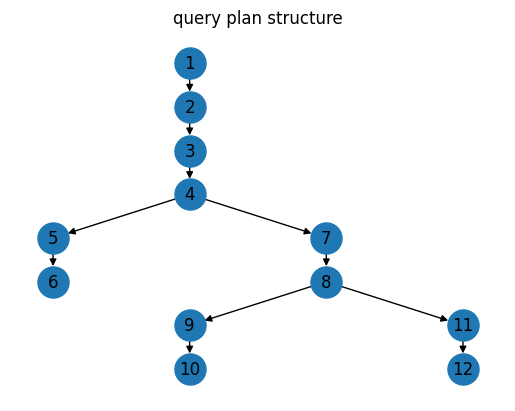

<Figure size 640x480 with 0 Axes>

In [18]:
from src.query_plan import QueryPlan
import networkx as nx
import matplotlib.pyplot as plt
qp = QueryPlan(query_plan_raw)
def make_digraph(self, draw=True):
    g = nx.DiGraph()
    for n_id, node in self.id_node.items():
        g.add_node(n_id, intro=node.node_ir(), subset=node.node_type)
    for _, node in self.id_node.items():
        if node.left is not None:
            g.add_edge(node.id, node.left.id)
        if node.right is not None:
            g.add_edge(node.id, node.right.id)
    if draw:
        plt.title('query plan structure')
        pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot')
        nx.draw(g, pos, with_labels=True, arrows=True, node_size=500)
        plt.show()
        plt.savefig('nx_test.png')
make_digraph(qp)

In [44]:
from src.query_plan import QueryPlanNode


def callback(cur_node: QueryPlanNode):
    print(f"id: {cur_node.id:02d}, parent: {cur_node.parent.id if cur_node.parent is not None else 0:02d}, layer: {cur_node.layer}, vector: {list(cur_node.to_vector())}")

qp.post_order(_callback=callback)

id: 06, parent: 05, layer: 5, vector: ['LEAF_NODE', 'parallel', 'SeqScan', 'movie_info', 'mi', 'filter', 'SIMPLE_COMPARE', 'info_type_id', '>', '*', 'condition', '34888.427']
id: 05, parent: 04, layer: 4, vector: ['MIDDLE_NODE', 'Sort', 'mi.movie_id', 'filter', 'condition', '64608.17']
id: 10, parent: 09, layer: 7, vector: ['LEAF_NODE', 'SeqScan', 'title', 't', 'filter', 'condition', '38904.126']
id: 09, parent: 08, layer: 6, vector: ['MIDDLE_NODE', 'Sort', '.id', 'filter', 'condition', '77278.979']
id: 12, parent: 11, layer: 7, vector: ['LEAF_NODE', 'SeqScan', 'movie_info_idx', 'mi_idx', 'filter', 'SIMPLE_COMPARE', 'info_type_id', '=', '*', 'condition', '0.046']
id: 11, parent: 08, layer: 6, vector: ['MIDDLE_NODE', 'Sort', 'mi_idx.movie_id', 'filter', 'condition', '0.085']
id: 08, parent: 07, layer: 5, vector: ['MIDDLE_NODE', 'MergeJoin', 'filter', 'condition', 'SIMPLE_COMPARE', 't.id', '=', '*', '77279.164']
id: 07, parent: 04, layer: 4, vector: ['MIDDLE_NODE', 'Materialize', 'filter

In [46]:
from src.cost_learner import CostLearner

c = CostLearner.default_factory()

In [47]:
c.cost_learner_net

CostLearnerNet(
  (lstm): BayesianLSTM(
    (weight_ih_sampler): TrainableRandomDistribution()
    (weight_hh_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_ih_prior_dist): PriorWeightDistribution()
    (weight_hh_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (relu_1): ReLU()
  (linear_1): Linear(in_features=32, out_features=16, bias=True)
  (relu_2): ReLU()
  (drop_out): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

In [50]:
raw = """
/*+ SeqScan(t) SeqScan(mk) HashJoin(t mk) Leading (( mk t )) */
explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;

Finalize Aggregate  (cost=159457.00..159457.01 rows=1 width=8)
  ->  Gather  (cost=159456.79..159457.00 rows=2 width=8)
        Workers Planned: 2
        ->  Partial Aggregate  (cost=158456.79..158456.80 rows=1 width=8)
              ->  Parallel Hash Join  (cost=79063.50..158456.43 rows=144 width=0)
                    Hash Cond: (mk.movie_id = t.id)
                    ->  Parallel Seq Scan on movie_keyword mk  (cost=0.00..79391.79 rows=144 width=4)
                          Filter: (keyword_id = 20450)
                    ->  Parallel Hash  (cost=61876.00..61876.00 rows=1375000 width=4)
                          ->  Parallel Seq Scan on title t  (cost=0.00..61876.00 rows=1375000 width=4)
JIT:
  Functions: 15
  Options: Inlining false, Optimization false, Expressions true, Deforming true
"""
print(raw)


/*+ SeqScan(t) SeqScan(mk) HashJoin(t mk) Leading (( mk t )) */
explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;

Finalize Aggregate  (cost=159457.00..159457.01 rows=1 width=8)
  ->  Gather  (cost=159456.79..159457.00 rows=2 width=8)
        Workers Planned: 2
        ->  Partial Aggregate  (cost=158456.79..158456.80 rows=1 width=8)
              ->  Parallel Hash Join  (cost=79063.50..158456.43 rows=144 width=0)
                    Hash Cond: (mk.movie_id = t.id)
                    ->  Parallel Seq Scan on movie_keyword mk  (cost=0.00..79391.79 rows=144 width=4)
                          Filter: (keyword_id = 20450)
                    ->  Parallel Hash  (cost=61876.00..61876.00 rows=1375000 width=4)
                          ->  Parallel Seq Scan on title t  (cost=0.00..61876.00 rows=1375000 width=4)
JIT:
  Functions: 15
  Options: Inlining false, Optimization false, Expressions true, Deforming true



In [52]:
from src.extract_table_names import extract_tables
sql = """
select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
"""
extract_tables(sql)

['t', 'mk']

In [56]:
b = """
/*+ SeqScan(t) SeqScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) IndexScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) IndexScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) IndexScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) IndexScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) IndexScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) IndexScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) BitmapScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) BitmapScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) BitmapScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) BitmapScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) BitmapScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) BitmapScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) SeqScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) SeqScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) SeqScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) SeqScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) SeqScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) SeqScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) IndexScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) IndexScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) IndexScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) IndexScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) IndexScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) IndexScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) BitmapScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) BitmapScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) BitmapScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) BitmapScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) BitmapScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ IndexScan(t) BitmapScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) SeqScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) SeqScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) SeqScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) SeqScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) SeqScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) SeqScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) IndexScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) IndexScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) IndexScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) IndexScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) IndexScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) IndexScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) BitmapScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) BitmapScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) BitmapScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) BitmapScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) BitmapScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ BitmapScan(t) BitmapScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
"""

print(b)


/*+ SeqScan(t) SeqScan(mk) NestLoop(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) MergeJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) HashJoin(t mk) Leading (( mk t )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) NestLoop(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) MergeJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.keyword_id = 20450;
/*+ SeqScan(t) SeqScan(mk) HashJoin(mk t) Leading (( t mk )) */ explain select count(*) from title t, movie_keyword mk where t.id=mk.movie_id and mk.key

In [54]:
new_raw = """
Aggregate  (cost=222530.13..222530.14 rows=1 width=8) (actual time=49233.640..49233.800 rows=1 loops=1)
  ->  Merge Join  (cost=80441.42..222529.26 rows=346 width=0) (actual time=582.397..49233.561 rows=17 loops=1)
        Merge Cond: (t.id = mk.movie_id)
        ->  Index Scan using title_pkey on title t  (cost=0.43..133834.36 rows=3300000 width=4) (actual time=0.031..25040.799 rows=3300000 loops=1)
        ->  Sort  (cost=80440.98..80441.84 rows=346 width=4) (actual time=490.550..490.794 rows=18 loops=1)
              Sort Key: mk.movie_id
              Sort Method: quicksort  Memory: 27kB
              ->  Gather  (cost=1000.00..80426.39 rows=346 width=4) (actual time=22.178..490.228 rows=50 loops=1)
                    Workers Planned: 2
                    Workers Launched: 2
                    ->  Parallel Seq Scan on movie_keyword mk  (cost=0.00..79391.79 rows=144 width=4) (actual time=48.532..388.985 rows=17 loops=3)
                          Filter: (keyword_id = 20450)
                          Rows Removed by Filter: 2493346
Planning Time: 10.906 ms
JIT:
  Functions: 19
  Options: Inlining false, Optimization false, Expressions true, Deforming true
  Timing: Generation 12.125 ms, Inlining 0.000 ms, Optimization 0.779 ms, Emission 25.524 ms, Total 38.428 ms
Execution Time: 49234.317 ms
"""

print(new_raw)



Aggregate  (cost=222530.13..222530.14 rows=1 width=8) (actual time=49233.640..49233.800 rows=1 loops=1)
  ->  Merge Join  (cost=80441.42..222529.26 rows=346 width=0) (actual time=582.397..49233.561 rows=17 loops=1)
        Merge Cond: (t.id = mk.movie_id)
        ->  Index Scan using title_pkey on title t  (cost=0.43..133834.36 rows=3300000 width=4) (actual time=0.031..25040.799 rows=3300000 loops=1)
        ->  Sort  (cost=80440.98..80441.84 rows=346 width=4) (actual time=490.550..490.794 rows=18 loops=1)
              Sort Key: mk.movie_id
              Sort Method: quicksort  Memory: 27kB
              ->  Gather  (cost=1000.00..80426.39 rows=346 width=4) (actual time=22.178..490.228 rows=50 loops=1)
                    Workers Planned: 2
                    Workers Launched: 2
                    ->  Parallel Seq Scan on movie_keyword mk  (cost=0.00..79391.79 rows=144 width=4) (actual time=48.532..388.985 rows=17 loops=3)
                          Filter: (keyword_id = 20450)
    

In [55]:
(5346925.973 - float(49233.800)) / 5346925.973

0.9907921298614172